# 鄰近傳播分群法(Affinity Propagation)

##### 先引入我們需要的packages

In [1]:
import os 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from numpy import random
from tqdm.notebook import tqdm

# MNIST Dataset

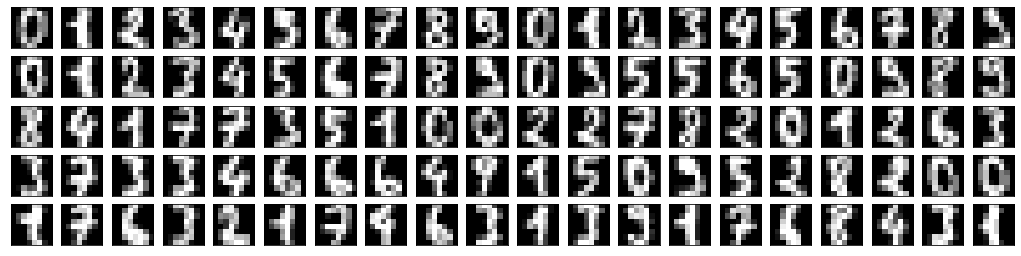

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X=digits.data/16
y=digits.target
plt.rcParams["figure.figsize"] = (18,18)
plt.gray() 
for i in range(100):
    plt.subplot(20, 20, i + 1)
    plt.imshow(digits.images[i], cmap=plt.cm.gray, vmax=16, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show() 

# Principal Component Anlysis

In [3]:
def PCA(X,n_components,N):
    X_center=X-np.mean(X,axis=0)
    W,D,V=np.linalg.svd(X_center.T)
    X_embedded=np.dot(X_center,W[:,:n_components])
    return X_embedded

# AP

In [4]:
N=X.shape[0]
max_iter=100
damping=0.5
convergence_iter=10
R=np.zeros((N,N))
A=np.zeros((N,N))
tmp = np.zeros((N,N))
S=-sp.spatial.distance.cdist(X,X,metric='sqeuclidean')
S+=np.diag(np.ones(N)*np.median(S.ravel()))
e = np.zeros((N, convergence_iter))
ind = np.arange(N)
for it in tqdm(range(max_iter)):
    np.add(A,S, tmp)
    I = np.argmax(tmp, axis=1)
    Y = tmp[ind, I]
    tmp[ind, I] = -np.inf
    Y2 = np.max(tmp, axis=1)
    np.subtract(S, Y[:, None], tmp)
    tmp[ind, I] = S[ind, I] - Y2
    tmp *= 1 - damping
    R *= damping
    R += tmp
    np.maximum(R, 0, tmp)
    tmp.flat[::N+1] = R.flat[::N+1]
    tmp -= np.sum(tmp, axis=0)
    dA = np.diag(tmp).copy()
    tmp.clip(0, np.inf, tmp)
    tmp.flat[::N+1] = dA
    tmp *= 1 - damping
    A *= damping
    A -= tmp
    E = (np.diag(A) + np.diag(R)) > 0
    e[:, it % convergence_iter] = E
    K = np.sum(E, axis=0)
    if it >= convergence_iter:
        se = np.sum(e, axis=1)
        unconverged = np.sum((se == convergence_iter) + (se == 0)) != N
        if (not unconverged and (K > 0)) or (it == max_iter):
            print("Converged after %d iterations." % it)
            break
I = np.flatnonzero(E)
K = I.size
c = np.argmax(S[:, I], axis=1)
c[I] = np.arange(K) 
for k in range(K):
    ii = np.where(c == k)[0]
    j = np.argmax(np.sum(S[ii[:, np.newaxis], ii], axis=0))
    I[k] = ii[j]
c = np.argmax(S[:, I], axis=1)
c[I] = np.arange(K)
labels = I[c]
cluster_centers_indices = np.unique(labels)
labels = np.searchsorted(cluster_centers_indices, labels)

Converged after 31 iterations.


# Compute Error Rate

In [5]:
y_pred=np.zeros(N)
for i in range(0,10):
    same_index=np.array(np.where(y[cluster_centers_indices]==i)).flatten()
    for j in same_index:
        BOOL=(labels==j)
        y_pred[BOOL]=i
y_pred=y_pred.astype(int)
print("Affinity Propagation Error Rate: ",1-np.sum(y_pred==y)/N)

Affinity Propagation Error Rate:  0.03060656649972171


# Plot

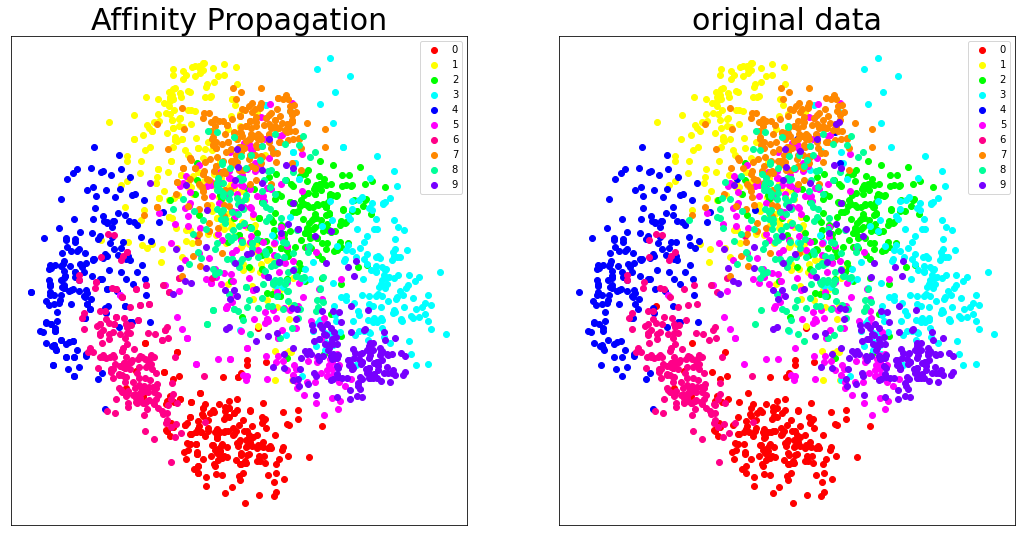

In [6]:
X_embedded=PCA(X,2,N)
color=["#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF",
       "#FF00FF","#FF0088","#FF8800","#00FF99","#7700FF"]
plt.rcParams["figure.figsize"] = (18,9)
fig , ax = plt.subplots()
plt.subplot(1, 2, 1)
for i in range(0,10):
    same_index=np.array(np.where(y[cluster_centers_indices]==i)).flatten()
    for j in same_index:
        BOOL=(labels==j)
        plt.scatter(X_embedded[BOOL,0],X_embedded[BOOL,1],c=color[i])
    plt.scatter(X_embedded[BOOL,0],X_embedded[BOOL,1],c=color[i],label=i)
plt.title("Affinity Propagation",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=10)
plt.subplot(1, 2, 2)
for i in range(0,10):
    BOOL=(y==i)
    plt.scatter(X_embedded[BOOL,0],X_embedded[BOOL,1],c=color[i],label=i)
plt.title("original data",fontsize=30)
plt.xticks([])
plt.yticks([])
plt.legend(fontsize=10)
plt.show()